# Imports

In [1]:
import json
from typing import Optional, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
# pip install scikit-learn
from sklearn.linear_model import LinearRegression, HuberRegressor

from statsmodels.stats.weightstats import DescrStatsW  # pip install statsmodels

# Var

In [2]:
shufflenet_0_1 = "/home/filipe/Workspace/dynff/results/exp-1/shufflenet/criticalfl/25-09-2025/fedavg_random_criticalfl_battery_False_dataset_cifar10_dir_0.1_seed_1/model_performance.json"
mobilenet_0_1 = "/home/filipe/Workspace/dynff/results/motivational/exp-2/mobilenet/fedavg_random_criticalfl_battery_False_dataset_cifar10_dir_0.1_seed_1/model_performance.json"
resnext_0_1 = ""

shufflenet_0_3 = "/home/filipe/Workspace/dynff/results/exp-1/shufflenet/criticalfl/25-09-2025/fedavg_random_criticalfl_battery_False_dataset_cifar10_dir_0.3_seed_1/model_performance.json"
mobilenet_0_3 = "/home/filipe/Workspace/dynff/results/motivational/exp-2/mobilenet/fedavg_random_criticalfl_battery_False_dataset_cifar10_dir_0.3_seed_1/model_performance.json"
resnext_0_3 = ""

shufflenet_1_0 = "/home/filipe/Workspace/dynff/results/exp-1/shufflenet/criticalfl/25-09-2025/fedavg_random_criticalfl_battery_False_dataset_cifar10_dir_1.0_seed_1/model_performance.json"
mobilenet_1_0 = "/home/filipe/Workspace/dynff/results/motivational/exp-2/mobilenet/fedavg_random_criticalfl_battery_False_dataset_cifar10_dir_1.0_seed_1/model_performance.json"
resnext_1_0 = ""

lstm = "/home/filipe/Workspace/dynff/results/exp-4/shakespeare/5epochs/08-10-2025/fedavg_random_constant_45_battery_False_dataset_shakespeare_dir_1.0_seed_1/model_performance.json"


# Functions

## Aux

In [3]:
def get_accuracy(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)

    accs = []

    for _, value in data.items():
        acc = value["cen_accuracy"]
        accs.append(acc)

    return accs


def ema_online(a, alpha=0.2):
    out = np.empty_like(a, dtype=float)
    out[0] = a[0]
    for t in range(1, len(a)):
        out[t] = alpha * a[t] + (1.0 - alpha) * out[t - 1]
    return out.tolist()

## Graphics

In [4]:
def plot_accs(accs: list, title: str = "Accuracy evolution"):
    # --- Plot ---
    plt.figure()
    plt.plot(accs, label="original")
    plt.grid(True)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_accuracies_by_dir(
        df,
        *,
        dir_order=None,  # ex.: [0.1, 0.3, 1.0]; se None usa ordem crescente do df
        legend_title="Accuracies",
        y_label="Test Accuracy",
        figsize=(12, 3.2),
        ylim=(0, 1),  # defina None para não fixar limites do y
):
    """Plota acurácias 'Raw' e 'Smoothed' por valor de dir (α) em subplots.

    Parâmetros
    ----------
    df : pandas.DataFrame
        Colunas: 'round' (int), 'dir' (float), 'smoothed' (bool), 'accuracy' (float)
    """
    required = {"round", "dir", "smoothed", "accuracy"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Colunas ausentes no DataFrame: {sorted(missing)}")

    # Ordenação e preparação
    df2 = df.sort_values(["dir", "smoothed", "round"])
    alphas = list(dir_order) if dir_order is not None else sorted(df2["dir"].unique())

    fig, axes = plt.subplots(1, len(alphas), sharey=True, figsize=figsize)
    axes = np.atleast_1d(axes)

    # Estilos e rótulos das duas séries
    # line_styles = {False: (0, (5, 2)), True: "solid"}   # dashed para Raw, sólido p/ Smoothed
    line_styles = {False: "solid", True: "solid"}  # dashed para Raw, sólido p/ Smoothed
    labels_map = {False: "Raw", True: "Smoothed"}

    x_min, x_max = df2["round"].min(), df2["round"].max()
    legend_handles = {}  # para montar a legenda global só com séries presentes

    for ax, a in zip(axes, alphas):
        sub = df2[df2["dir"] == a]

        for sm in (False, True):
            ss = sub[sub["smoothed"] == sm]
            if ss.empty:
                continue
            h, = ax.plot(
                ss["round"], ss["accuracy"],
                lw=2, linestyle=line_styles[sm],
                label=labels_map[sm],
            )
            legend_handles[labels_map[sm]] = h

        ax.set_title(rf"$\alpha = {a:g}$")
        ax.set_xlabel("Rounds")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.set_xlim(x_min, x_max)
        if ylim is not None:
            ax.set_ylim(*ylim)

    axes[0].set_ylabel(y_label)

    # Legenda única no topo
    if legend_handles:
        fig.legend(
            legend_handles.values(),
            legend_handles.keys(),
            loc="upper center",
            ncol=len(legend_handles),
            title=legend_title,
            frameon=False,
        )

    fig.tight_layout(rect=[0, 0, 1, 0.90])
    return fig, axes


## Detection

In [5]:
def _ajusta_reta(ywin: np.ndarray, metodo: Literal["ols", "huber"] = "ols"):
    """
    Ajusta y ~ a + b*x em x = [0, 1, ..., W-1] e retorna (a, b, yhat_ini, yhat_fim).
    """
    W = len(ywin)
    x = np.arange(W).reshape(-1, 1)
    if metodo == "huber":
        reg = HuberRegressor()
    else:
        reg = LinearRegression()
    reg.fit(x, ywin)
    a = float(getattr(reg, "intercept_", 0.0))
    b = float(reg.coef_[0])
    yhat_ini = a + b * 0.0
    yhat_fim = a + b * (W - 1)
    return a, b, yhat_ini, yhat_fim


def primeiro_indice_estavel_por_regressao(
        y,
        W: int,
        K: int,
        delta: float,
        metodo: Literal["ols", "huber"] = "ols",
        start_after: Optional[int] = None,
        indice_1_based: bool = True
) -> Optional[int]:
    """
    Varre janelas de tamanho W e considera 'ok' quando |ŷ_fim - ŷ_ini| <= delta.
    Retorna o ÚLTIMO índice da ÚLTIMA janela do primeiro bloco de K janelas 'ok'
    consecutivas (i.e., o índice de término da K-ésima janela na sequência).

    Parâmetros:
      - y: sequência numérica (lista/array).
      - W: tamanho da janela.
      - K: nº de janelas 'ok' consecutivas necessárias.
      - delta: margem máxima aceitável para |ŷ_fim - ŷ_ini|.
      - metodo: "ols" (mínimos quadrados) ou "huber" (robusto).
      - start_after: começar a verificar APENAS após este índice na série.
          * Interpretação em mesma base de 'indice_1_based'.
          * Ex.: se indice_1_based=True e start_after=100, só avaliaremos
            janelas cujo índice final seja > 100 (1-based).
      - indice_1_based: se True, o retorno e 'start_after' são 1-based.

    Retorno:
      - Índice (conforme 'indice_1_based') do fim da última janela 'ok' da
        primeira sequência com K consecutivas; ou None se não detectar.
    """
    y = np.asarray(y, float)
    N = y.size
    if N < W:
        return None

    # Converter start_after para base 0 (estritamente após)
    if start_after is None:
        start_after_0 = -1  # qualquer fim >= 0 estará "após"
    else:
        start_after_0 = (start_after - 1) if indice_1_based else start_after

    run = 0
    # t percorre o "pós-índice" de término da janela: janela y[t-W:t] termina em t-1
    for t in range(W, N + 1):
        end0 = t - 1  # índice 0-based de término da janela atual
        if end0 <= start_after_0:
            continue  # ainda não passou do start_after

        yy = y[t - W:t]
        _, _, y0, y1 = _ajusta_reta(yy, metodo=metodo)
        ok = (abs(y1 - y0) <= delta)

        run = run + 1 if ok else 0
        if run >= K:
            # Detecção: retornamos o índice de término desta janela (K-ésima 'ok' consecutiva)
            return (end0 + 1) if indice_1_based else end0

    return None


In [50]:
def plot_accuracies_by_dir(
        df,
        *,
        dir_order=None,
        legend_title="Accuracies",
        y_label="Test Accuracy",
        figsize=(12, 3.2),
        ylim=(0, 1),
        cps=None,
        phase_colors=("#fde68a", "#c7d2fe", "#bbf7d0"),  # amarelo, roxo, verde
):
    required = {"round", "dir", "smoothed", "accuracy"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Colunas ausentes no DataFrame: {sorted(missing)}")

    df2 = df.sort_values(["dir", "smoothed", "round"])
    alphas = list(dir_order) if dir_order is not None else sorted(df2["dir"].unique())
    if cps is not None and len(cps) != len(alphas):
        raise ValueError(f"Esperava {len(alphas)} cps (um por dir), mas recebi {len(cps)}.")

    rounds_sorted = np.sort(df2["round"].unique())
    x_min, x_max = int(rounds_sorted[0]), int(rounds_sorted[-1])

    # Fixed = round na posição de 80% dos rounds únicos
    idx80 = int(np.floor(0.8 * (len(rounds_sorted) - 1)))
    x_fixed = int(rounds_sorted[idx80])

    fig, axes = plt.subplots(1, len(alphas), sharey=True, figsize=figsize)
    axes = np.atleast_1d(axes)

    line_styles = {False: "solid", True: "solid"}
    labels_map = {False: "Raw", True: "Smoothed"}
    legend_handles = {}

    # Heurística: quando usar "rnds" em vez de "rounds"
    def _unit(delta):
        total_w = max(x_max - x_min, 1)
        # se o espaço de seta for pequeno, encurta
        return "rnds" if delta < 0.14 * total_w else "rounds"

    for j, (ax, a) in enumerate(zip(axes, alphas)):
        sub = df2[df2["dir"] == a]

        # Curvas
        for sm in (False, True):
            ss = sub[sub["smoothed"] == sm]
            if ss.empty:
                continue
            h, = ax.plot(ss["round"], ss["accuracy"], lw=2, linestyle=line_styles[sm],
                         label=labels_map[sm])
            legend_handles[labels_map[sm]] = h

        # Limites e grades
        ax.set_title(rf"$\alpha = {a:g}$")
        ax.set_xlabel("Rounds")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.set_xlim(x_min, x_max)
        if ylim is not None:
            ax.set_ylim(*ylim)

        # ----- geometria vertical (tudo abaixo da(s) curva(s)) -----
        y0, y1 = ax.get_ylim()
        yr = max(y1 - y0, 1.0)
        y_min_curve = sub["accuracy"].min() if not sub.empty else (y0 + 0.20 * yr)

        # Base para nomes (na "linha de rodapé" das anotações, mas dentro do eixo)
        y_base = max(y0 + 0.05 * yr, y_min_curve - 0.10 * yr)

        # pistas para as setas: 1ª (Auto) logo acima dos nomes; 2ª (Fixed) bem acima
        lane1 = y_base + 0.15 * yr#min(y_base + 0.15 * yr, y_min_curve - 0.015 * yr)   # seta do Auto
        lane2 = lane1 + 0.15 * yr#min(lane1 + 0.15 * yr,  y_min_curve - 0.20 * yr)   # seta do Fixed (mais alta)

        # ----- posições horizontais -----
        x_auto = int(cps[j]) if (cps is not None) else None

        # ----- faixas (sempre: antes de Auto | entre Auto e Fixed | depois de Fixed) -----
        if x_auto is not None:
            # ordem de desenho ajuda a manter a sensação “amarelo/roxo/verde”
            ax.axvspan(x_min, x_auto, facecolor=phase_colors[0], alpha=0.30, zorder=0.1)
            ax.axvspan(min(x_auto, x_fixed), max(x_auto, x_fixed),
                       facecolor=phase_colors[1], alpha=0.30, zorder=0.2)
            ax.axvspan(x_fixed, x_max, facecolor=phase_colors[2], alpha=0.30, zorder=0.0)
        else:
            ax.axvspan(x_min, x_fixed, facecolor=phase_colors[0], alpha=0.30, zorder=0.1)
            ax.axvspan(x_fixed, x_max, facecolor=phase_colors[2], alpha=0.30, zorder=0.0)

        # ----- linhas verticais -----
        if x_auto is not None:
            ax.axvline(x_auto, color="k", linestyle="--", linewidth=1.4, alpha=0.9, zorder=3)
        ax.axvline(x_fixed, color="k", linestyle=":", linewidth=1.4, alpha=0.9, zorder=3)

        # ----- rótulos na base, dentro das cores -----
        # label_bbox = dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.5)

        if x_auto is not None:
            # sempre à esquerda da linha de cp para garantir que fique na amarela
            ax.annotate("Auto",
                        xy=(x_auto, y_base), xytext=(-8, 0),
                        textcoords="offset points", ha="right", va="baseline",
                        fontsize=9, zorder=5, clip_on=False)#bbox=label_bbox, zorder=5, clip_on=False)

        # “Fixed” deve ficar do lado interno da roxa:
        #   se fixed > auto, roxa está à esquerda do fixed → alinhar à esquerda da linha
        #   se fixed < auto, roxa está à direita do fixed → alinhar à direita da linha
        if x_auto is not None and x_fixed > x_auto:
            fx_offset, fx_ha = (-8, "right")
        else:
            fx_offset, fx_ha = (8, "left")
        ax.annotate("Fixed",
                    xy=(x_fixed, y_base), xytext=(fx_offset, 0),
                    textcoords="offset points", ha=fx_ha, va="baseline",
                    fontsize=9, zorder=5, clip_on=False)#bbox=label_bbox, zorder=5, clip_on=False)

        # ----- setas e rótulos de distância -----
        # 1ª seta (acima dos nomes), partindo de cp
        if x_auto is not None:
            d_auto = int(x_max - x_auto)
            if d_auto != 0:
                ax.annotate("", xy=(x_max, lane1), xytext=(x_auto, lane1),
                            arrowprops=dict(arrowstyle="<->", linewidth=1.2, alpha=0.95),
                            zorder=4)
                unit = _unit(d_auto)
                ax.text((x_max + x_auto) / 2.0, lane1 + 0.01 * yr,
                        f"{d_auto} {unit}", ha="center", va="bottom", fontsize=9,
                        # bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5),
                        zorder=5)

        # 2ª seta (acima da 1ª), partindo de fixed
        d_fixed = int(x_max - x_fixed)
        if d_fixed != 0:
            ax.annotate("", xy=(x_max, lane2), xytext=(x_fixed, lane2),
                        arrowprops=dict(arrowstyle="<->", linewidth=1.2, alpha=0.95),
                        zorder=4)
            unit = _unit(d_fixed)
            ax.text((x_max + x_fixed) / 2.0, lane2 + 0.01 * yr,
                    f"{d_fixed} {unit}", ha="center", va="bottom", fontsize=9,
                    # bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5),
                    zorder=5)

    axes[0].set_ylabel(y_label)

    if legend_handles:
        fig.legend(
            legend_handles.values(), legend_handles.keys(),
            loc="upper center", ncol=len(legend_handles),
            title=legend_title, frameon=False,
        )

    fig.tight_layout(rect=[0, 0, 1, 0.90])
    return fig, axes


# Process

In [55]:
mobilenet_0_1_accs_orig = get_accuracy(mobilenet_0_1)[:150]
mobilenet_0_1_accs = ema_online(mobilenet_0_1_accs_orig, 0.1)

mobilenet_0_3_accs_orig = get_accuracy(mobilenet_0_3)[:150]
mobilenet_0_3_accs = ema_online(mobilenet_0_3_accs_orig, 0.1)

mobilenet_1_0_accs_orig = get_accuracy(mobilenet_1_0)[:150]
mobilenet_1_0_accs = ema_online(mobilenet_1_0_accs_orig, 0.1)

shufflenet_0_1_accs_orig = get_accuracy(shufflenet_0_1)[:150]
shufflenet_0_1_accs = ema_online(shufflenet_0_1_accs_orig, 0.1)

shufflenet_0_3_accs_orig = get_accuracy(shufflenet_0_3)[:150]
shufflenet_0_3_accs = ema_online(shufflenet_0_3_accs_orig, 0.1)

shufflenet_1_0_accs_orig = get_accuracy(shufflenet_1_0)[:150]
shufflenet_1_0_accs = ema_online(shufflenet_1_0_accs_orig, 0.1)

lstm_accs_orig = get_accuracy(lstm)[:150]
lstm_accs = ema_online(lstm_accs_orig, 0.1)

In [56]:
# Mapeando cada combinação (dir, smoothed) → lista de valores
data = {
    (0.1, True): mobilenet_0_1_accs,
    (0.1, False): mobilenet_0_1_accs_orig,
    (0.3, True): mobilenet_0_3_accs,
    (0.3, False): mobilenet_0_3_accs_orig,
    (1.0, True): mobilenet_1_0_accs,
    (1.0, False): mobilenet_1_0_accs_orig,
}

# Verificação rápida: todas as listas com o mesmo tamanho
n_set = {len(v) for v in data.values()}
if len(n_set) != 1:
    raise ValueError("Todas as listas precisam ter o mesmo tamanho.")
N = n_set.pop()

# Constrói o dataframe em formato long/tidy
frames = []
for (d, s), vals in data.items():
    frames.append(pd.DataFrame({
        "round": range(1, N + 1),  # índice 1-based; use range(N) se preferir 0-based
        "dir": d,
        "smoothed": s,
        "accuracy": vals
    }))
df = pd.concat(frames, ignore_index=True)

df

,round,dir,smoothed,accuracy
0,1,0.1,True,0.1000
1,2,0.1,True,0.1000
2,3,0.1,True,0.1000
3,4,0.1,True,0.1000
4,5,0.1,True,0.1000
...,...,...,...,...
895,146,1.0,False,0.8186
896,147,1.0,False,0.8207
897,148,1.0,False,0.8285
898,149,1.0,False,0.8199


In [57]:
cp_0_1_mobilenet = primeiro_indice_estavel_por_regressao(
    mobilenet_0_1_accs, W=10, K=5, delta=1e-2, metodo="huber",
    start_after=20,  
    indice_1_based=True
)

cp_0_3_mobilenet = primeiro_indice_estavel_por_regressao(
    mobilenet_0_3_accs, W=10, K=5, delta=1e-2, metodo="huber",
    start_after=20,  
    indice_1_based=True
)

cp_1_0_mobilenet = primeiro_indice_estavel_por_regressao(
    mobilenet_1_0_accs, W=10, K=5, delta=1e-2, metodo="huber",
    start_after=20,  
    indice_1_based=True
)

cps = [cp_0_1_mobilenet, cp_0_3_mobilenet, cp_1_0_mobilenet]

# Graphics

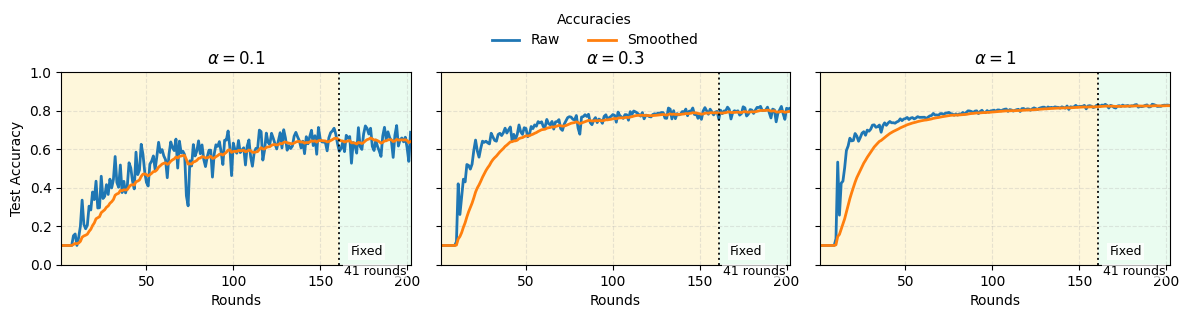

In [35]:
fig, axes = plot_accuracies_by_dir(df)

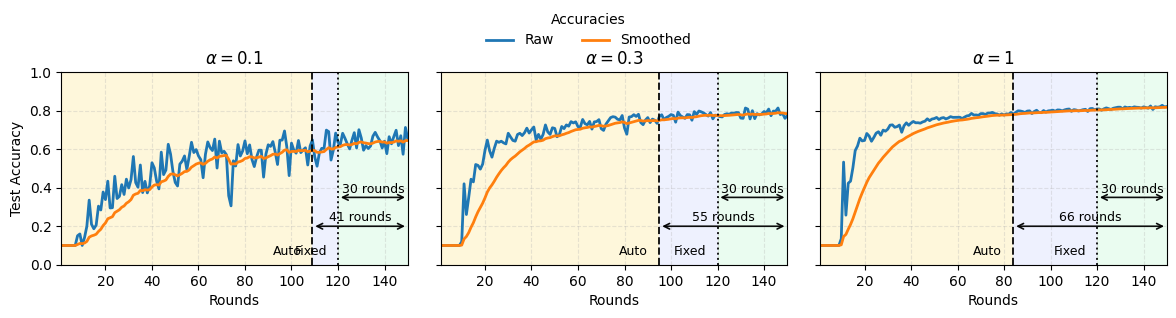

In [58]:
fig, axes = plot_accuracies_by_dir(df, cps=cps)

# Tests

## Rupturas + Tost

50
[np.int32(11), np.int32(22), np.int32(32), 50]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

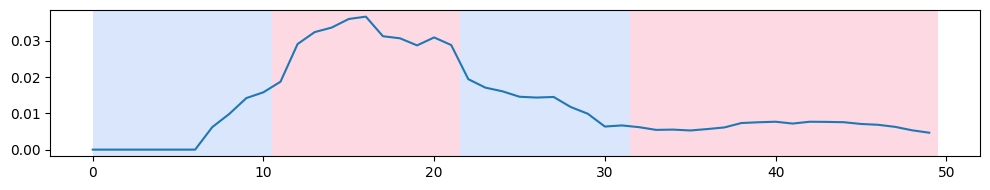

In [417]:
np_mobilenet_0_1_accs_orig = np.array(mobilenet_0_1_accs_orig[:50])

diffs = np.diff(np_mobilenet_0_1_accs_orig)
n = diffs.size
sigma2 = float(np.var(diffs, ddof=1))
penalty = float(2.0 * sigma2 * np.log(max(n, 2)))  # penalidade tipo BIC escalada

algo = rpt.KernelCPD(kernel="linear", min_size=10).fit(np_mobilenet_0_1_accs_orig)  # written in C
bkps = algo.predict(pen=penalty)
print(len(np_mobilenet_0_1_accs_orig))
print(bkps)

rpt.display(np_mobilenet_0_1_accs_orig, bkps)

In [418]:
def tost_diferencas_slice_statsmodels(x, i, j, bound=1e-3, alpha=0.05):
    """
    Mesmo teste acima, mas usando statsmodels: testa se mean(diff) ∈ [-bound, +bound].
    """
    x = np.asarray(x, float)
    d = np.diff(x[i:j])
    ds = DescrStatsW(d)
    pval, lower, upper = ds.ttost_mean(-bound, +bound)  # retorna p-value do TOST e as duas metades
    return (pval < alpha), (pval, lower, upper)


# uso
ok, info = tost_diferencas_slice_statsmodels(mobilenet_0_1_accs_orig, 32, 50, 0.001, 0.05)
print(ok, info)


True (np.float64(2.1231559300953504e-06), (np.float64(6.802581198490936), np.float64(2.1231559300953504e-06), np.float64(16.0)), (np.float64(-8.149482216926815), np.float64(2.1789071006069172e-07), np.float64(16.0)))


## Tost + Regressão Linear

In [482]:
# Exemplo 1: detectar sem restrição de início (1-based por padrão)
# idx_fim = primeiro_indice_estavel_por_regressao(mobilenet_0_3_accs, W=30, K=5, delta=5e-4, metodo="huber")
# print("Detecção (fim da última janela K):", idx_fim)

# Exemplo 2: só começar a checar após o índice 120 (1-based)
idx_fim = primeiro_indice_estavel_por_regressao(
    mobilenet_0_1_accs, W=10, K=5, delta=1e-2, metodo="huber",
    start_after=20,  # só considera janelas cujo fim > 120
    indice_1_based=True
)
print("Detecção após 20 (fim da última K):", idx_fim)

# Exemplo 3: trabalhando tudo 0-based
# idx_fim_0 = primeiro_indice_estavel_por_regressao(
#     mobilenet_0_3_accs, W=30, K=5, delta=5e-4, metodo="ols",
#     start_after=20,   # 0-based
#     indice_1_based=False
# )
# print("Detecção 0-based:", idx_fim_0)


Detecção após 20 (fim da última K): 109


## Kneedle algo

In [459]:
import numpy as np
from kneed import KneeLocator

# epochs 1..N e vetor de perdas
x = np.arange(1, len(mobilenet_0_1_accs) + 1)
y = np.asarray(mobilenet_0_1_accs, float)

# Perda costuma ser decrescente e "convexa" (elbow).
kl = KneeLocator(
    x, y,
    curve="concave",  # 'convex' => detectar cotovelo
    direction="increasing",  # curva cai da esquerda p/ direita
    S=100.001,  # ajuste a sensibilidade (1, 3, 5, 10...)
    interp_method="interp1d",  # ou "polynomial" (+suave) 
    online=True  # corrige o joelho com dados novos
)

knee_epoch = kl.knee  # índice (x) do joelho
knee_value = kl.knee_y  # perda no joelho
print(knee_epoch, knee_value)


194 0.651412909969088


## Penalized Spline

In [419]:
"""Monotone smoothing splines implementation using penalized B-splines (aka. P-splines).

Solves the equation

    (B'B + λD3'D3 + κD1'VD1)α = B'y

where

    B'B: The least squares part
    λD3'D3: The smoothing part
    κD1'VD1: The monotonicity part
    α: The coefficients of the B-spline basis functions

The algorithm was introduced in [Eilers2005]

References:
-----------
[Eilers2005]: Eilers, P. H. C. 2005. Unimodal smoothing. Journal of Chemometrics
              19:317–328. DOI:10.1002/cem.935.
"""

import warnings

from scipy.interpolate import BSpline


class MaxIterationWarning(UserWarning): ...


def create_pspline(
        x_train,
        y_train,
        bspline_degree=3,
        knot_segments=10,
        lambda_smoothing=0.1,
        kappa_penalty=10 ** 6,
        maxiter: int = 30,
) -> BSpline:
    """Creates a B-Spline (with penalties it's called P-Spline) instance using the
    give data and parameters.

    Parameters
    ----------
    x_train: array-like
        The x-coordinates of the training data.
    y_train: array-like
        The y-coordinates of the training data.
    bspline_degree: int
        The degree of the B-spline (which is also the degree of the fitted spline
        function). The order of the splines is degree + 1.
    knot_segments: int
        number of inter-knot segments between min(x_train) and max(x_train). Defines the
        number of internal knots, which is knot_segments + 1. The total amount of knots
        is calculated as `bspline_degree * 2 + knot_segments + 1`; Few knots will be
        added outside of the `x_train` range to fix boundary effects.
    lambda_smoothing: float
        The smoothing parameter. Higher values will result in smoother curves.
    kappa_penalty: float
        The penalty parameter for enforcing monotonicity. Higher values will result in
        more monotonic curves. kappa_penalty of 0 means that monotonicity is not
        enforced at all.
    maxiter: int
        Maximum number of iterations for the algorithm. If the algorithm does not
        converge within this number of iterations, a warning is issued.
    """

    knot_interval = (max(x_train) - min(x_train)) / knot_segments

    # You need to add deg knots on each side of the interval. See, for example,
    # De Leeuw (2017) Computing and Fitting Monotone Splines
    # The basic interval is [min(x_train), max(x_train)], and
    # the extended interval is [min(knots), max(knots)].
    # You may only ask for values within the basic interval, as there are always m
    # (=deg+1) non-zero B-splines. Outside the basic interval, there are less B-splines
    # with non-zero values and the model is extrapolating.
    knots = np.linspace(
        min(x_train) - (bspline_degree + 1) * knot_interval,
        max(x_train) + (bspline_degree + 1) * knot_interval,
        bspline_degree * 2 + knot_segments + 1,
    )
    alphas = np.ones(len(x_train))

    # Introduced in scipy 1.8.0
    B = BSpline.design_matrix(x=x_train, t=knots, k=bspline_degree).toarray()
    n_base_funcs = B.shape[1]
    I = np.eye(n_base_funcs)
    D3 = np.diff(I, n=3, axis=0)
    D1 = np.diff(I, n=1, axis=0)

    # Monotone smoothing
    V = np.zeros(n_base_funcs - 1)

    B_gram = B.T @ B
    A = B_gram + lambda_smoothing * D3.T @ D3
    BTy = B.T @ y_train
    for _ in range(maxiter):

        W = np.diag(V * kappa_penalty)
        # The equation
        # (B'B + λD3'D3 + κD1'VD1)α = B'y
        alphas = np.linalg.solve(A + D1.T @ W @ D1, BTy)
        V_new = (D1 @ alphas < 0) * 1
        dv = np.sum(V != V_new)
        V = V_new
        if dv == 0:
            break
    else:
        warnings.warn(
            "Max iteration reached. The results are not reliable.", MaxIterationWarning
        )

    return BSpline(knots, alphas, bspline_degree, extrapolate=False)

In [ ]:
for idx in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]:
    x = np.array([idx for idx in range(len(shufflenet_0_1_accs_orig[:idx]))])
    y = np.array(shufflenet_1_0_accs_orig[:idx])
    x_valid = np.linspace(min(x), max(x), 1000)
    spline = create_pspline(x, y, lambda_smoothing=100.0, knot_segments=idx // 10)
    print(f"------------start {idx}-----------------")
    plt.plot(x, y, label="raw values", marker="o", ls="", color="lightgray")
    plt.plot(x_valid, spline(x_valid), label="spline", ls="--", color="red")
    plt.plot(x, spline(x), label="spline (train)", marker="o", ls="", color="red")
    plt.legend()
    plt.grid(ls="--", lw=0.5, color="lightgray")
    plt.show()
    print(f"-------------------------------------")
    derivada_spline = spline.derivative(nu=1)
    plt.plot(x, derivada_spline(x), label="first deriv", marker="o", ls="", color="lightgray")
    plt.legend()
    plt.grid(ls="--", lw=0.5, color="lightgray")
    plt.show()
    print(f"-------------------------------------")
    derivadas = derivada_spline(x)
    print(derivadas)
    print(f"------------end {idx}-----------------")

# Usar Tost + Regressão Linear no teste 